In [111]:
import sys

import numpy as np
import numpy.linalg as la
from qiskit import quantum_info as qi 

import matplotlib.pyplot as plt
import math
from scipy.linalg import sqrtm 
from scipy import linalg as sc_la

# http://cvxr.com/cvx/
import cvxpy as cp
import numpy as np

from joblib import Parallel, delayed
import time

from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit

from matplotlib import rc #For Latex fonts
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [79]:
def is_pos_semidef(x):
    precission = 10**-4
    l=la.eigvalsh(x)
    return np.all(l >= -precission*la.norm(l,1)/len(l))

def randn_mat(n,k):
    return (np.random.randn(n,k) + 1j*np.random.randn(n,k))/math.sqrt(2.0) 

def rand_haar_ket(n):
    psi=np.random.randn(n)+1j*np.random.randn(n)
    return psi/la.norm(psi)

def rand_haar_state(n):
    ket = rand_haar_ket(n)
    return np.outer(ket,np.conj(ket).T)

def randh_state_ensbl(d,n):
    ensbl = []
    for i in range(n):
        ensbl.append(rand_haar_state(d))
    return ensbl

def rand_POVM(k,d,r):
    # PRXQuantum.1.020307
    POVM = []
    M = []
    S = np.zeros((d,d))*1j
    
    for i in range(k):
        A = randn_mat(d,r)
        B = A@np.conj(A).T
        M.append(B)
        S += B
    
    for i in range(k):
        S_inv = sqrtm(la.inv(S))
        POVM.append( S_inv@M[i]@S_inv )
        
    return POVM

def POVM_stats(rho,POVM,n):
    rng = np.random.default_rng()
    p = []
    for i in range(len(POVM)):
        p.append( np.trace(rho@POVM[i]).real )
    
    return rng.multinomial(n,p)

def POVM_ensbl_stats(ensbl,POVM,n):
    ens_stats = []
    for i in range(len(ensbl)):
        ens_stats.append(POVM_stats(ensbl[i],POVM,n))
        
    return ens_stats

# Pure SDP solution
def PLS(M,ensbl,n_samp,norm=2):
    v = np.asarray(POVM_ensbl_stats(ensbl,M,n_samp))/n_samp
    d = len(M[0])
    X = []
    for i in range(len(M)):
        X += [cp.Variable((d,d), hermitian=True) ]

    cost = []
    for i in range(len(ensbl)):
        for j in range(len(M)):
            cost+=[ cp.real( cp.trace(ensbl[i] @ X[j]) - v[i][j] ) ]

    expr = cp.norm(cp.vstack(cost),norm)

    constraints = [ cp.sum(X) - np.identity(d) == np.zeros((d,d)) ]
    constraints += [cp.atoms.norm_nuc.normNuc(X[i]) <= cp.trace(X[i]) for i in range(len(M))]

    prob = cp.Problem(cp.Minimize(expr), constraints)
    prob.solve()

    POVM_PLS = []
    for i in range(len(M)):
        POVM_PLS.append(X[i].value)
        
    cost_min = prob.value
    
    cond_check = [np.trace(cp.sum(X).value) - d < 10**-9]
    
    for i in range(len(M)):
        cond_check += [is_pos_semidef(X[i].value)]
        #np.linalg.eigvalsh(X[i].value)
        
    cond_violation = [constraints[0].violation()]
    for i in range(len(constraints)-1):
        cond_violation += [constraints[i+1].violation()/2]
        
    return POVM_PLS, cost_min, cond_check, cond_violation
    
def OS_POVM_Estimator(M,ensbl,array):
    # One-Shot estimator
    
    k = len(M)
    d = len(M[0])
    n_samp = len(ensbl)
    
    POVM_OneShot = [np.zeros((d,d))+np.zeros((d,d))*1j for _ in range(k)]
    M_step = np.empty(len(array),dtype=list)

    j=0
    for i in range(n_samp):
        measrmt = POVM_stats(ensbl[i],M,1)
        out = int(np.where(measrmt==1)[0])
        POVM_OneShot[out] += d*((d+1)*ensbl[i]-np.eye(d))
        if(i in [a-1 for a in array]):
            M_step[j] = [X*(1/i) for X in POVM_OneShot]
            j+=1
    
    return M_step

def operator_distance(M,N):
    k = len(M)
    d = len(M[0])
    
    dif = [X - Y for X, Y in zip(M,N)]
    op_norm = np.max( [sc_la.norm(Z,np.inf) for Z in dif] )

    return op_norm

def Block_Choi(M):
    k = len(M)
    d = len(M[0])
    choi = np.zeros((d*k,d*k)) + 1j*np.zeros((d*k,d*k))
    
    for i in range(k):
        choi += np.kron(np.outer(basis(k,i),np.conj(basis(k,i)).T),M[i])

    return choi

# Qiskit Implementation DIAMOND-NORM
def diamond_distance_Q(M,N):
    k = len(M)
    d = len(M[0])
    choi = np.zeros((d*k,d*k)) + 1j*np.zeros((d*k,d*k))
    
    for i in range(k):
        choi += np.kron(np.outer(basis(k,i),np.conj(basis(k,i)).T),M[i]-N[i])

    return qi.diamond_norm(qi.Choi(choi,input_dims=d,output_dims=k))    

# CVX Implementation DIAMOND-NORM
def diamond_distance(M,N):
    d2 = len(M)
    d1 = len(M[0])
    n = d1*d2
    
    J = 1j*np.zeros((n,n))
    for i in range(d2):
        J += np.kron(np.outer(basis(d2,i),np.conj(basis(d2,i)).T),M[i]-N[i])
    
    Y1 = cp.Variable((n,n),hermitian=True)
    Y0 = cp.Variable((n,n),hermitian=True)
    M1 = cp.hstack([Y0,-J])
    M2 = cp.hstack([-J.T.conj(),Y1])
    M = cp.vstack([M1,M2])
    
    constraints = [M>>0]
    
    cf = cp.Minimize( 0.5*(cp.norm(cp.partial_trace(Y0,[d1,d2],axis=1))+cp.norm(cp.partial_trace(Y1,[d1,d2],axis=1))))
    prob = cp.Problem(cf,constraints)
    prob.solve()
    
    return prob.value

def diamond_norm(J,d1,d2):
    n = d1*d2
    
    Y1 = cp.Variable((n,n),hermitian=True)
    Y0 = cp.Variable((n,n),hermitian=True)
    M1 = cp.hstack([Y0,-J])
    M2 = cp.hstack([-J.T.conj(),Y1])
    M = cp.vstack([M1,M2])
    
    constraints = [M>>0]
    
    cf = cp.Minimize( 0.5*(cp.norm(cp.partial_trace(Y0,[d1,d2],axis=1))+cp.norm(cp.partial_trace(Y1,[d1,d2],axis=1))))
    prob = cp.Problem(cf,constraints)
    prob.solve()
    
    return prob.value

def POVM_Affine_P(POVM_E):
    k = len(POVM_E)
    d = len(POVM_E[0])
    
    # Reformulate as vector problem (MAt(d²)^k -> vec(k*d²))
    M_re = np.reshape(POVM_E,(d*k,d))
    M_re = np.reshape(M_re,(1,d**2*k)).T
    
    # Linear operator describing sum of measurement operators
    A = []
    for i in range(k):
        A.append(np.eye(d**2))
    
    A = np.reshape(A,(d**2*k,d**2)).T
    
    # Take pseudoinverse of A
    A_inv = la.pinv(A)

    # Affine offset for A(X+Y)=id => Y = A⁺id
    # reshaped to vector form
    Y = A_inv@(np.eye(d).reshape(d**2,1))
    
    ### Affine Projection ###
    
    # Compute Kernel of A
    # Columns of 'A_kern' are kernel vectors (d**2*k,dim(kern))    [Comp_Error of ~e-17]
    A_kern = sc_la.null_space(A)

    # Inner product of 'estimated POVM' minus 'affine Shift', with Kernel of A.
    Kern_P = A_kern.T@(M_re-Y)
    
    # Build Projected POVM onto the linear space 'AX=0' via linear combination of Kernel vectors.
    M_p = np.zeros((d**2*k,1))

    for i in range(len(Kern_P)):
        v_kern = A_kern.T[i].reshape(k*d**2,1)
        M_p = M_p + Kern_P[i]*v_kern

    # Final Affine projection by adding back the affine shift vector 'Y'.
    M_affine = M_p + Y

    # Reshape back to matrix form
    M_affine = np.reshape(M_affine,(d*k,d))
    M_affine = np.reshape(M_affine,(k,d,d))
    
    return M_affine

def PSD_P(E):
    # Systematic error ~e-16
    k = len(E)
    F = []
    for i in range(k):
        E_herm = (E[i] + np.conj(E[i]).T)/2
        e,V = la.eigh(E[i])
        H = V@np.diag(np.abs(e))@np.conj(V.T)
        E_res = (E_herm + H) / 2
        F.append((E_res + np.conj(E_res).T) / 2)

    return F


In [47]:
d,r,k = [7,4,6]
M = rand_POVM(k,d,r)


In [80]:
# POVM Estimation
steps = [5,10,20,40,80,160,320,640,1280,2560]

ensbl = randh_state_ensbl(d,max(steps))
M_LS = OS_POVM_Estimator(M,ensbl,steps)


In [121]:
np.save("./Data/imshow_cover/imshow_cover_drk_{}_{}_{}_minmax_{}_{}.npy".format(d,r,k,min(steps),max(steps)),M_LS)

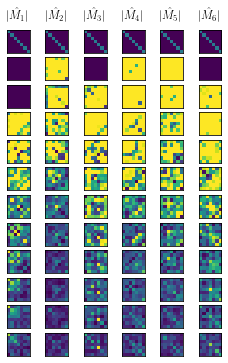

In [119]:
fontsize = 24
vmin = np.min([np.min(np.abs(X)) for X in M ])
vmax = np.max([np.max(np.abs(X)) for X in M ])

### Plot

fig = plt.figure(figsize=(4, 6))
gs = GridSpec(12,k, figure=fig,hspace=0.2)

M0 = [np.eye(d)/k for _ in range(k) ]
#vmin,vmax = [0,.4]
vmin = np.min([np.min(np.abs(X)) for X in M ])
vmax = np.max([np.max(np.abs(X)) for X in M ])

for i in range(k):
    ax0 = fig.add_subplot(gs[0, i])
    #vmin = np.min([np.min(np.abs(X)) for X in M0 ])
    #vmax = np.max([np.max(np.abs(X)) for X in M0 ])
    ax0.imshow(np.abs(M0[i]), cmap='viridis',vmin=vmin, vmax=vmax)
    ax0.set_title('$|\hat M_%d|$'%(i+1),fontsize=12, y=1.25, x=0.5)
    ax0.tick_params(left = False, right = False , labelleft = False ,
            labelbottom = False, bottom = False)
    for j in range(10):    
        ### Estimator Plot
        ax2 = fig.add_subplot(gs[j+1, i])
        #vmin = np.min([np.min(np.abs(X)) for X in M_LS[j] ])
        #vmax = np.max([np.max(np.abs(X)) for X in M_LS[j] ])
        ax2.imshow(np.abs(M_LS[j][i]), cmap='viridis',vmin=vmin, vmax=vmax)
        ax2.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
        
    ### True POVM Plot
    ax1 = fig.add_subplot(gs[11, i])
    #vmin = np.min([np.min(np.abs(X)) for X in M ])
    #vmax = np.max([np.max(np.abs(X)) for X in M ])
    ax1.imshow(np.abs(M[i]), cmap='viridis',vmin=vmin, vmax=vmax)
    ax1.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    
TEXpath = '/home/HAL-7559/Documents/Tex/Master/QMT/thesis/img/'
#plt.savefig("{}Imshow_cover.png".format(TEXpath),bbox_inches="tight",dpi=200)